In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Bitcoin.csv to Bitcoin.csv
User uploaded file "Bitcoin.csv" with length 218553 bytes


In [6]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Bitcoin.csv')
display(df.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [8]:
# Convert 'Date' to datetime and extract date features
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])  # Remove rows with invalid dates

In [10]:
# Extract year, month, day from timestamp
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [11]:
# Drop unwanted columns
df = df.drop(columns=['timestamp', 'name', 'timeOpen', 'timeClose', 'timeHigh', 'timeLow'], errors='ignore')

In [13]:
# Convert numeric columns to proper float format
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'] # Corrected column names
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [14]:
df = df.dropna()  # Remove any rows with missing values

In [18]:
# Feature-target split
X = df.drop(columns=['Close', 'Date'])
y = df['Close']

In [19]:
# Feature-target split (drop 'Date' to avoid dtype error)
X = df.drop(columns=['Close', 'Date'])  # remove Date (datetime64) column
y = df['Close']

# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# Evaluate linear regression
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nModel Trained Successfully!")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Predicted values (first 5): {y_pred[:5]}")


Model Trained Successfully!
Mean Squared Error: 0.00
Predicted values (first 5): [38402.22265598  5750.79980501  6419.66015601   386.54901101
   228.57299801]


In [21]:
# Random Forest with cross-validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

In [22]:
rf_model = RandomForestRegressor(random_state=42)

In [23]:
cv_rmse = cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
print("Cross-validation RMSE (before tuning):", -cv_rmse.mean())

Cross-validation RMSE (before tuning): 109.0816689725096


In [25]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

In [26]:
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [27]:
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [28]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best CV RMSE: 117.5595177225174


In [29]:
# Test the best model
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [30]:
y_pred = best_rf.predict(X_test)

In [31]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [33]:
print(f"\nTest MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Test MAE: 29.36
Test MSE: 13298.37
Test RMSE: 115.32
R² Score: 0.9999


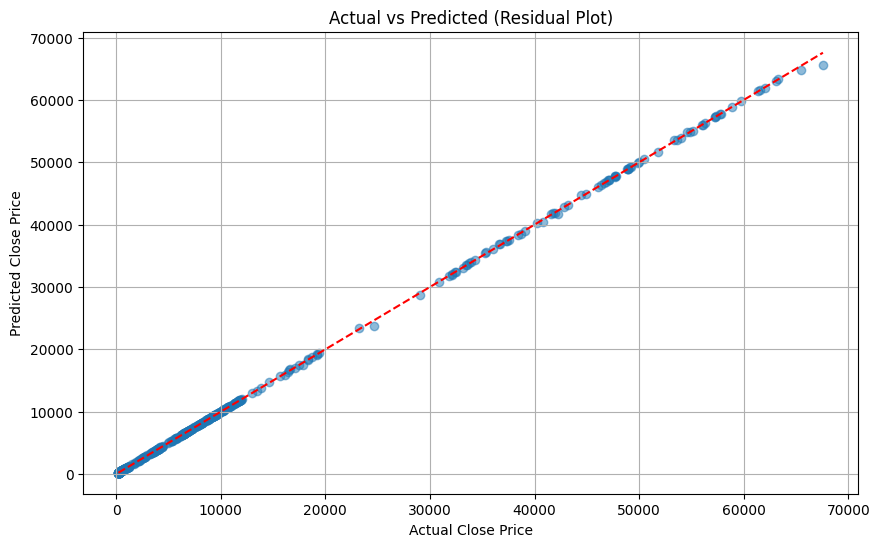

In [34]:
# Residual plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted (Residual Plot)')
plt.grid(True)
plt.show()

In [35]:
# Pipeline and model saving
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [36]:
# Define numeric features
numeric_features = X_train.columns.tolist()

In [37]:
# Preprocessing pipeline (standardization)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

In [38]:
# Combine preprocessing with model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_rf)
])

In [39]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Open', 'High', 'Low',
                                                   'Adj Close', 'Volume',
                                                   'year', 'month', 'day'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=200,
                                       random_state=42))])

In [40]:
# Full pipeline for GridSearch
full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

In [42]:
# Hyperparameter tuning within pipeline
param_grid_pipeline = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5]
}

In [43]:
grid_pipeline = GridSearchCV(
    full_pipeline,
    param_grid=param_grid_pipeline,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [44]:
grid_pipeline.fit(X_train, y_train)
print("Best Pipeline Parameters:", grid_pipeline.best_params_)
best_pipeline_model = grid_pipeline.best_estimator_

Best Pipeline Parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}


In [45]:
# Save pipeline
import joblib
joblib.dump(best_pipeline_model, 'bitcoin_price_pipeline.joblib')

['bitcoin_price_pipeline.joblib']